# Walking-LSTM-Predict-Between-RGB-Greenscreen

In [1]:
from util import *
from util.parser import *
from util.saver import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from util.tf_ops import *
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
from time import time
from skimage.measure import compare_ssim as ssim
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/Rishabh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Load Train and Test Data

In [2]:
def convert_to_float(collection):
    return [x/255 for x in collection]

In [3]:
train_collection =  get_collection("../data/data/walking/64x64x3/greenscreen_train")
train_collection = convert_to_float(train_collection)
#train_collection = augment_reverse_color(train_collection)
#train_collection = augment_reverse_sequence(train_collection)
train_collection = center_collections(train_collection)

# total number of images
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

walk_greenscreen_1
walk_greenscreen_3
walk_greenscreen_2
walk_greenscreen_6

After Augmentation: img_collections has 4 collections, 5937 images in total


In [4]:
test_collection = get_collection("../data/data/walking/64x64x3/greenscreen_test")
test_collection = convert_to_float(test_collection)
#test_collection = augment_reverse_color(test_collection)
test_collection = center_collections(test_collection)
# total number of images
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

walk_greenscreen_4

After Augmentation: Test set has 1 collections, 1723 images in total


## Sample

In [5]:
def sample(collection, batch_size = 8, gap = 1, seq_size = 3):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        (train_input, train_gd)
        
        train_input: [batch size, seq_size, 32, 32]
        train_gd:    [batch size, seq_size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !" 
    
    def expand_start_to_seq(start_ind):
        """
        Input:
            start_ind: a number indicating index of start frame
        Output:
            np array of [start_ind, start_ind + gap +1, start_ind + 2*(gap+1) ...]
        """
        return np.array([start_ind + i * (gap + 1) for i in range(seq_size)])
    
    
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # start-index for each class
    start_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - (gap + 1) * seq_size), avg_num_per_class, replace=False)
            start_ind.append(s)
        except: # if not enough in this class
            print("err")
            start_ind.append(np.array([]))
    selected_classes = [i for i in range(n_collection) if start_ind[i].shape[0]>0]
    train_ind = [[expand_start_to_seq(s) for s in ind] for ind in start_ind] # train indexes for each class
    gd_ind = [[(x + (gap+1)//2) for x in ind_by_class] for ind_by_class in train_ind]
    train_input = np.concatenate([np.stack([collection[i][j] for j in train_ind[i]]) for i in selected_classes], axis = 0)
    train_gd =  np.concatenate([np.stack([collection[i][j] for j in gd_ind[i]]) for i in selected_classes], axis = 0)
    
    train_input, train_gd = train_input[:batch_size], train_gd[:batch_size]
    return train_input, train_gd


def sample_train(batch_size = 8, gap = 1, seq_size = 3): return sample(train_collection, batch_size, gap = gap, seq_size = seq_size)

def sample_test(batch_size = 8, gap = 1, seq_size = 3):  return sample(test_collection, batch_size, gap, seq_size = seq_size)


## Sample of Training Data

Range of Image Piece Value: [-1.0, 1.0]
seq_input shape:            (4, 6, 32, 32, 3)
seq_gd    shape:            (4, 6, 32, 32, 3)


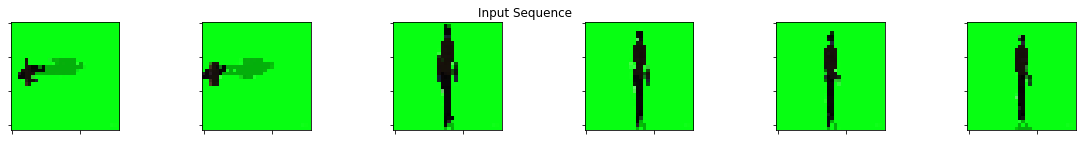

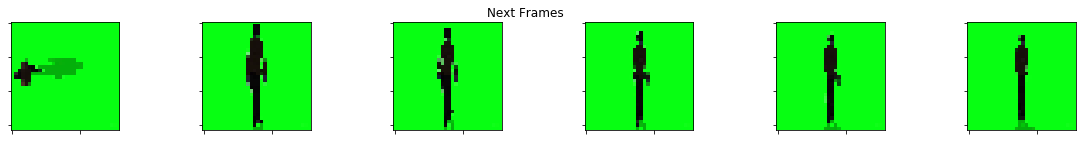

In [6]:
def show_sample_train(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_train(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_train(batch_size = 4, gap = 7, seq_size=6)

### Sample of Test Data

Range of Image Piece Value: [-1.0, 1.0]
seq_input shape:            (2, 5, 32, 32, 3)
seq_gd    shape:            (2, 5, 32, 32, 3)


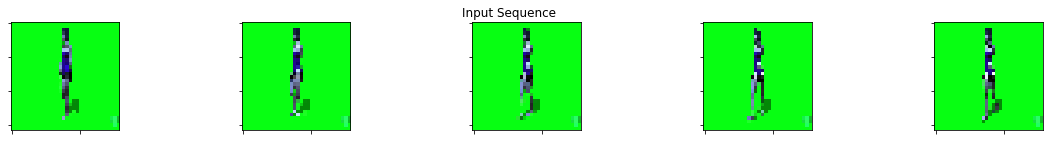

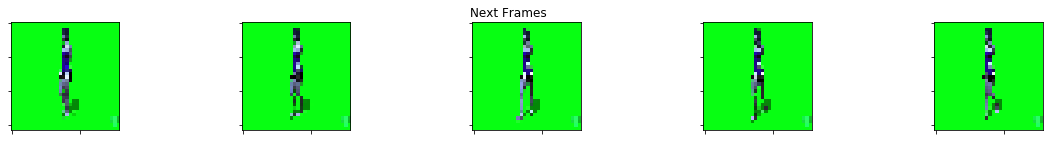

In [7]:
def show_sample_test(batch_size, gap, seq_size):
    seq_input, seq_gd = sample_test(batch_size=batch_size, gap=gap, seq_size= seq_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(seq_input), np.max(seq_input)))
    print("seq_input shape:            {}".format(seq_input.shape))
    print("seq_gd    shape:            {}".format(seq_gd.shape))
    selected = np.random.choice(range(batch_size))
    size = (20, 2)
    plot_images_ndarray(seq_input[selected], title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd[selected], title="Next Frames", size = size)
    
show_sample_test(batch_size = 2, gap = 5, seq_size=5)

# Param

In [8]:
seq_size         = 9 #9
feature_size     = 1024*4    # size of feature vector for LSTM
lstm_state_size  = feature_size   # size of hidden state: [lstm_state_size, lstm_state_size]

num_iteration    = 5000 #4000
gap              = 1
batch_size       = 4
learning_rate    = 1.6e-4
beta             = 0.9

assert feature_size%64 == 0, "feature_size must be divisable by 64!"
feature_channels = int(feature_size/8/8)

model_save_path = "trained_model/LSTM_box_32x32/{}/".format(time())

## Create Directory for Model to be saved

In [9]:
try:
    os.mkdir(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

# Encoder

In [10]:
def encode_img(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, feature_size]
    """
    x = img
    x = tf.reshape(img, [-1, 32, 32, 3])
    
    x = tf.layers.conv2d(x, filters = 32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)

    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channels, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.contrib.layers.flatten(x)
    return x

In [11]:
def encode_seq(img_seq, seq_size = seq_size):
    """
    Input:
        img_seq: sequence of images      Tensor         [batch_size, seq_size, 32, 32]
    Output:
        encoded feature of the sequence  List of Tensor [batch_size, feature_size] of length seq_size
    """
    img_seq = tf.transpose(img_seq, perm=[1, 0, 2, 3, 4]) # [seq_size, batch_size, 32, 32, 3]
    
    return [encode_img(img_seq[i]) for i in range(seq_size)]

# Decoder

In [12]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = tf.reshape(feature, [-1, 8, 8, feature_channels])
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=3, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    return img

## Loss

In [13]:
def get_loss(gd_imgs, output_imgs):
    """
    Input:
        gd_imgs, output_imgs: [batch_size, seq_size, 8, 8, 1]
    Output:
        scaler loss
    """
    #gd_imgs, output_imgs = tf.contrib.layers.flatten(gd_imgs), tf.contrib.layers.flatten(output_imgs)
    return tf.norm(gd_imgs - output_imgs)

In [14]:
def scale_loss(loss, seq_size = seq_size, batch_size = batch_size):
    return loss/seq_size/batch_size/2*255

### Solver

In [15]:
def get_solver(beta1=0.5, learning_rate=1e-3): #learning_rate=1e-3, 
    #global_step = tf.Variable(0, trainable=False)
    #learning_rate = tf.train.exponential_decay(1e-4, global_step, 100, 0.96, staircase=False)

    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(loss)

## Computation Graph

In [16]:
tf.reset_default_graph()

batch_seq        = tf.placeholder(tf.float32, [None, seq_size, 32, 32, 3], name = "batch_seq")
batch_next       = tf.placeholder(tf.float32, [None, seq_size, 32, 32, 3], name = "batch_next")
is_training      = tf.placeholder(tf.bool, (), name = "is_training")

feature_seq      = encode_seq(batch_seq)

lstm_cell1       = rnn.BasicLSTMCell(lstm_state_size)
# lstm_cell2       = rnn.BasicLSTMCell(lstm_state_size)
# Cell             = rnn.MultiRNNCell([lstm_cell1, lstm_cell2])
Cell = lstm_cell1
output_feature, states = rnn.static_rnn(Cell, feature_seq, dtype=tf.float32)

output_imgs = tf.stack([decode(f) for f in output_feature], axis=1)  # [seq_size, batch_size, 32, 32, 1]

loss = get_loss(batch_next, output_imgs)


#solver = get_solver(learning_rate, beta)

train_step = get_solver(beta) #learning_rate, #solver.minimize(loss)

# add to saver
tf.add_to_collection('output_batch_img', output_imgs)
tf.add_to_collection('loss', loss)

In [17]:
def train(sess, train_step, loss, batch_size, num_iteration, \
          plot_every = 400, show_loss_every=400, num_plot = 6,  save_every = 1000):
    losses = []
    learning_rate_cache = []
    saver = tf.train.Saver()
    for i in range(1, num_iteration+1):
        # get a sample
        gap = 1 #np.random.choice([1,3,5,7,9])
        seq_input, seq_gd = sample_train(batch_size, gap, seq_size = seq_size)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        #tf.train.exponential_decay(1.6e-3, 100, 10000, 0.96)
        sess.run([train_step], dic)
        curr_loss = sess.run(loss, dic)
        curr_loss = scale_loss(curr_loss)# tweek loss to match report loss
        
        losses.append(curr_loss)
        learning_rate_cache.append(learning_rate)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  loss = {} | Gap = {} | Learning Rate={}".format(i, curr_loss, gap, learning_rate))
            
        if i%plot_every == 0:
            seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
            seq_generated = sess.run(output_imgs, feed_dict=\
                                      {batch_seq: seq_input, batch_next: seq_gd, is_training: False})
            seq_generated = seq_generated[0]
            plot_batch_images(seq_generated[:num_plot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
            
        #if i%save_every == 0:
        #    saver.save(sess, model_save_path, global_step = i)   
    #save_learning_curve(iterations = list(range(1, num_iteration+1)), loss = losses, \
     #                       save_path = "output/learning_curve/box_LSTM-64x64-{}".format(time()))
    return losses, learning_rate_cache

In [18]:
#save_learning_curve

# Train

Iteration 1:  loss = 1045.0239372253418 | Gap = 1 | Learning Rate=0.00016


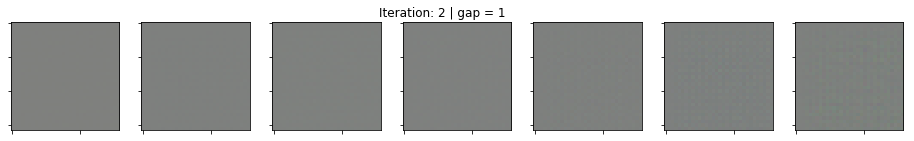

Iteration 2:  loss = 994.1255569458008 | Gap = 1 | Learning Rate=0.00016


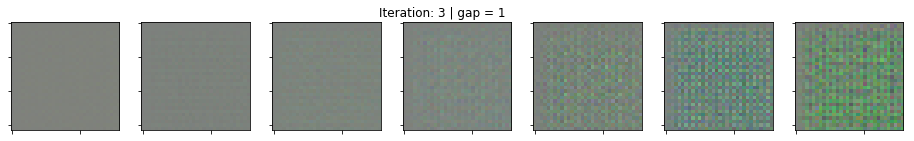

Iteration 3:  loss = 938.4513092041016 | Gap = 1 | Learning Rate=0.00016


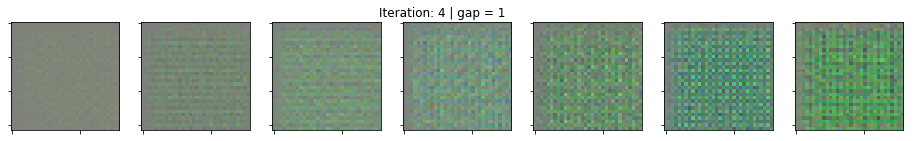

Iteration 4:  loss = 877.8357187906901 | Gap = 1 | Learning Rate=0.00016


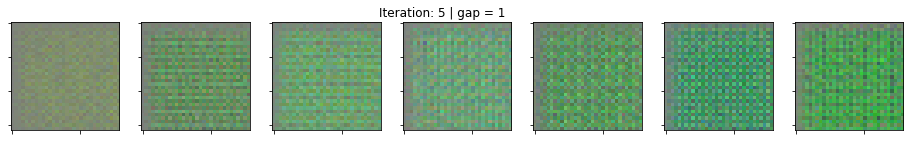

In [19]:
sess = get_session()
sess.run(tf.global_variables_initializer())
losses, learning_rate_cache = train(sess, train_step, loss, batch_size, num_iteration, \
               plot_every = 50, show_loss_every = 50, num_plot=7,  save_every = 7000)

## Plot Learning Curve

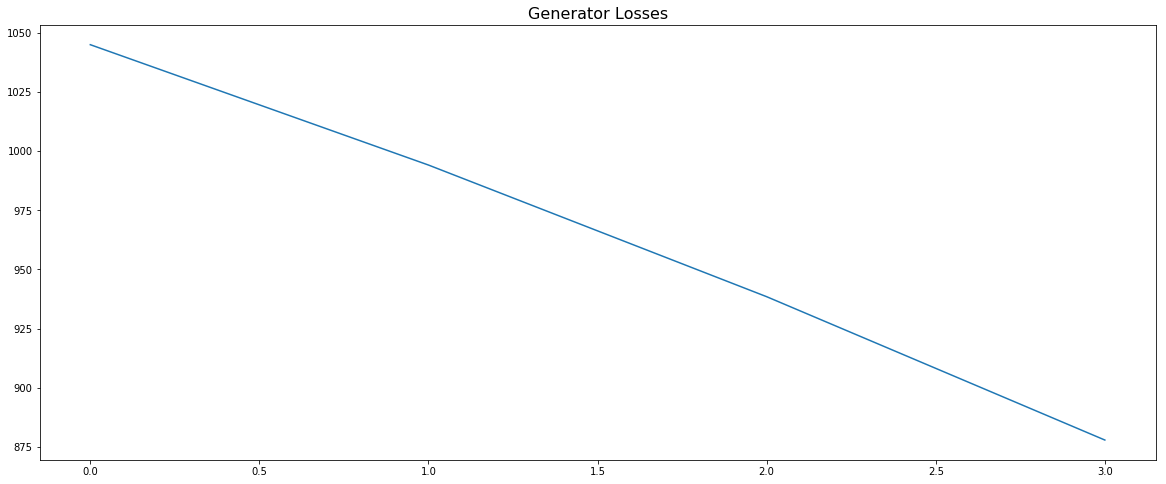

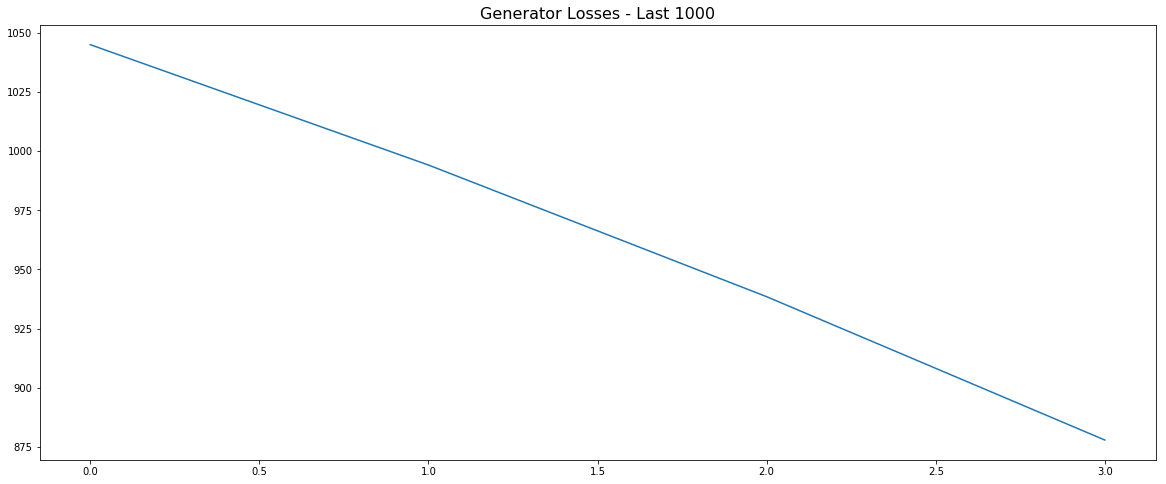

In [20]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(losses)
plt.title("Generator Losses", fontsize=16)
plt.show()

#plt.figure(figsize=figsize)
#plt.plot(learning_rate_cache)
#plt.title("Learning Rate", fontsize=16)
#plt.show()

plt.figure(figsize=figsize)
plt.plot(losses[-100:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [29]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size, seq_size = 3):
    losses = []
    for _ in range(num_run):
        if name == "train": seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
        else:               seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size)
        dic = {batch_seq: seq_input, batch_next: seq_gd, is_training: True}
        curr_loss = sess.run(loss, dic)
        losses.append(curr_loss)
    return scale_loss(np.mean(losses))

In [30]:
def get_generation(seq_input):
    feed_dict={batch_seq: seq_input, is_training: False}
    gen_batch = sess.run(output_imgs, feed_dict)
    return gen_batch

In [54]:
#def show_generations(name, seq_size = 6, gap = 3):
#    if name == "train":  seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
#    else:                seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size)
#    
#    seq_generated = get_generattion(seq_input)
#    seq_generated, seq_input, seq_gd = seq_generated[0], seq_input[0], seq_gd[0]
#    size = (20, 2)
#    plot_images_ndarray(seq_input, title="Input Sequence", size = size)
#    plot_images_ndarray(seq_gd, title="Next Frames - Ground Truth", size = size)
#    plot_images_ndarray(seq_generated, title="Next Frames - Generated", size = size)
    
    
def show_generations(name, seq_size = 6, gap = 3):
    if name == "train":  seq_input, seq_gd = sample_train(1, gap, seq_size = seq_size)
    else:                seq_input, seq_gd = sample_test(1, gap, seq_size = seq_size) 
    
    seq_generated = get_generation(seq_input)
    seq_generated, seq_input, seq_gd = seq_generated[0], seq_input[0], seq_gd[0]
    size = (20, 2)
    plot_images_ndarray(seq_input, title="Input Sequence", size = size)
    plot_images_ndarray(seq_gd, title="Next Frames - Ground Truth", size = size)
    plot_images_ndarray(seq_generated, title="Next Frames - Generated", size = size)

    
    return seq_generated

## - Evaluate on Training Data

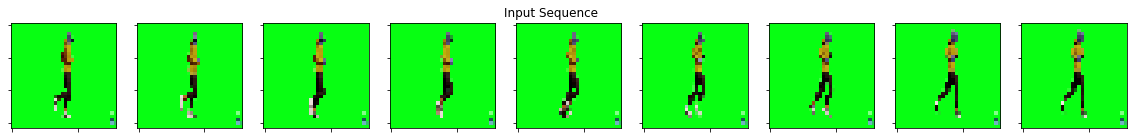

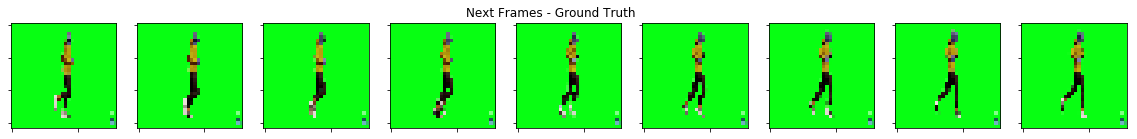

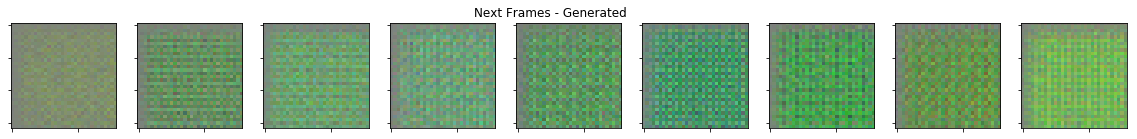

Training Loss = 440.0815900166829


In [55]:
def eval_train(seq_size = 3, gap = 3):
    seq_generated=show_generations("train", seq_size, gap)
    loss = report_loss("train", 100, gap, batch_size, seq_size = seq_size)
    print("Training Loss = {}".format(loss))
    return seq_generated, loss

seq_generated, train_loss = eval_train(seq_size = seq_size, gap = gap)

## - Evaluate on Test Data

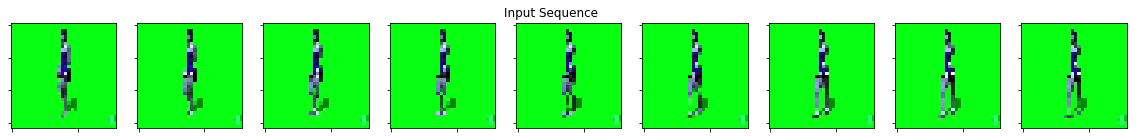

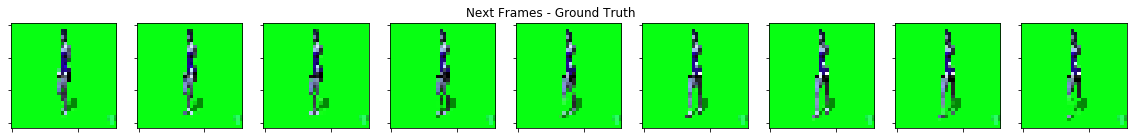

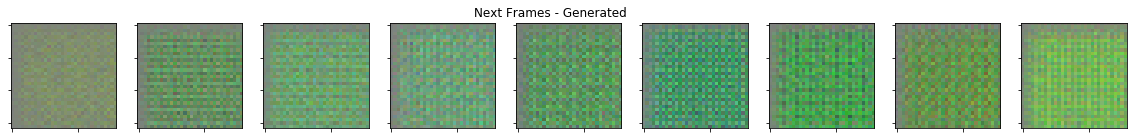

Test Loss = 447.3496913909912


In [46]:
#def eval_test(seq_size = 3, gap = 3):
#    show_generations("test", seq_size, gap)
#    loss = report_loss("test", 100, gap, batch_size, seq_size = seq_size)
#    print("Test Loss = {}".format(loss))
#    return loss

#test_loss = eval_test(seq_size = seq_size, gap = gap)

def eval_test(seq_size = 3, gap = 3, batch_size = batch_size):
    gen_batch=show_generations("test", seq_size, gap)
    loss = report_loss("test", 100, gap, batch_size, seq_size = seq_size)
    print("Test Loss = {}".format(loss))
    return loss, gen_batch

#test_collection = get_collection(".../data/walking/test")
#test_collection = augment_reverse_color(test_collection)
#test_collection = center_collections(test_collection)
test_loss,gen_batch = eval_test(seq_size = 9, gap=1, batch_size = 8)

In [56]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

(Test Loss - Train Loss)/Train Loss = 0.016515349742380187


In [57]:
#print(gen_batch.shape)
gen=gen_batch.reshape(9,32,32,3)
print(gen.shape)

(9, 32, 32, 3)


In [59]:
ssim_output=np.zeros(9)
for i in range(9):
    ssim_output[i]=ssim(seq_generated[i,:,:,:],gen[i,:,:,:], multichannel=True)

ssim_score=np.mean(ssim_output)
print("SSIM (Structural similarity) = {}".format(ssim_score))

SSIM (Structural similarity) = 0.9999908147407319


In [61]:
PNR=20*np.log10(255/test_loss)
print("PNR (Peak to Noise Raio) = {}".format(PNR))

PNR (Peak to Noise Raio) = -4.882139232854717
